# Part 3

In this part, I will analyse the correlation between the variables, scale them and create dummies.

In [1]:
import pandas as pd
import numpy as np
#Connect to API
from datetime import date
import datetime

#Library for Plotting
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

#Library for Data Preprocessing and Cleaning
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Library for Google Colab
from google.colab import drive

#Mount Google Drive on kernel
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/

# 1. Load datasets

In [3]:
detrend_train = pd.read_csv(path+'/train_diff_59.csv', index_col='quarter')
detrend_train.head()

,Categ_name,cci,DI,CS,GT,vix,3m Bond,CPI
quarter,,,,,,,,
2005Q1,Mail & Package Delivery: 1150,-3.366667,6074,185,1.666667,-1.663333,0.062,0.2
2005Q1,Kitchen & Dining: 951,-3.366667,6074,1337,0.333333,-1.663333,0.062,0.2
2005Q1,Animal Products & Services: 882,-3.366667,6074,730,5.000000,-1.663333,0.062,0.2
2005Q1,Auto Insurance: 467,-3.366667,6074,943,22.666667,-1.663333,0.062,0.2
2005Q1,Meat & Seafood: 909,-3.366667,6074,3951,-2.666667,-1.663333,0.062,0.2


In [4]:
detrend_test = pd.read_csv(path+'/test_diff_59.csv', index_col='quarter')

Text(0, 0.5, 'CPI')

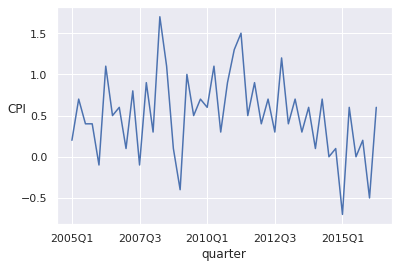

In [5]:
graph_train_CPI = detrend_train[ detrend_train.Categ_name=='Automotive Industry: 1190']

graph_train_CPI['CPI'].plot()
plt.ylabel('CPI',rotation=0)

# 2. Correlation

Let'S have a look at the correlation between the variables and our target variable 'Consumer Spending'.

In [6]:
corr_matrix=detrend_train.corr(method='pearson')
corr_matrix['CS'].sort_values(ascending=False)

CS         1.000000
GT         0.013060
cci        0.009607
3m Bond    0.006762
vix       -0.001143
DI        -0.005469
CPI       -0.013127
Name: CS, dtype: float64

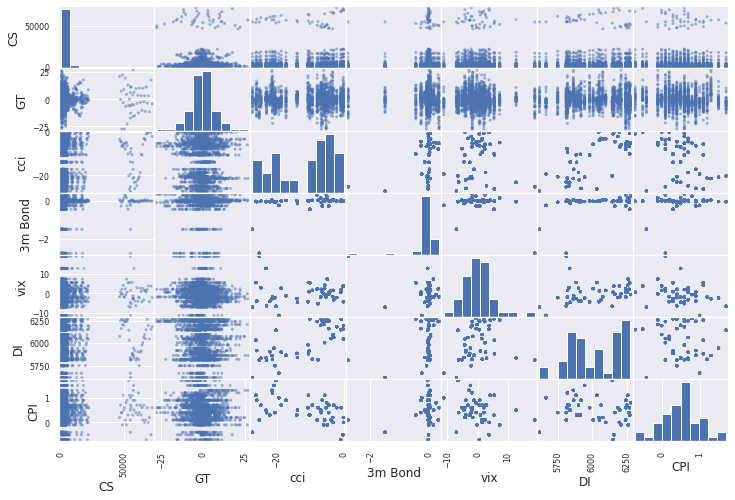

In [7]:
from pandas.plotting import scatter_matrix

# select only the variables that are most likely to be correlated
attributes = ["CS", 'GT', "cci", "3m Bond","vix", 'DI', 'CPI']
scat_mat = scatter_matrix(detrend_train[attributes], figsize=(12, 8))

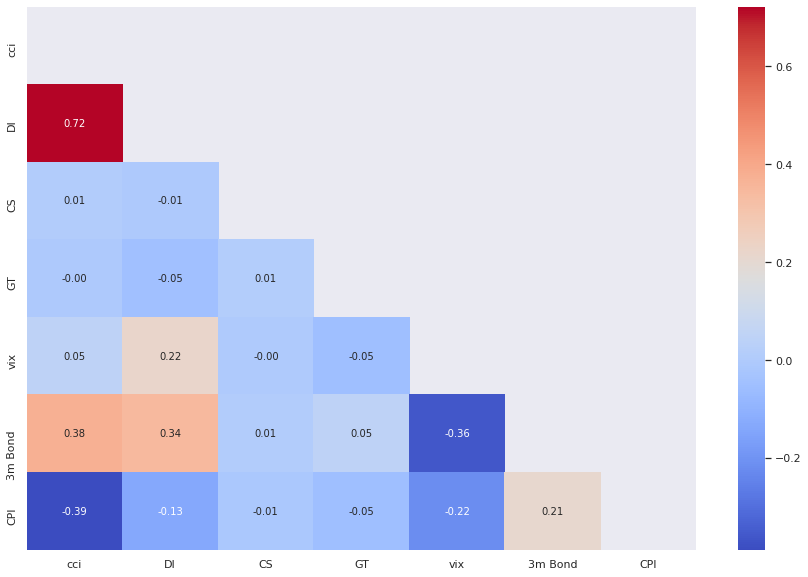

In [8]:
plt.figure(figsize = (15,10))
matrix= np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot = True,cmap= 'coolwarm', fmt='.2f', mask=matrix)

# 3. Scaling

I will scale every variable, except the target variable. But its lagged values will have to be scaled, so I will have to keep one on the side.

## 3.1 Train dataset

In [9]:
# we put the columns that we want to standardize in another
train_predictors= detrend_train.loc[:,['GT', 'DI', '3m Bond', 'cci', 'CPI','vix','Categ_name','CS']]
train_predictors.head()

,GT,DI,3m Bond,cci,CPI,vix,Categ_name,CS
quarter,,,,,,,,
2005Q1,1.666667,6074,0.062,-3.366667,0.2,-1.663333,Mail & Package Delivery: 1150,185
2005Q1,0.333333,6074,0.062,-3.366667,0.2,-1.663333,Kitchen & Dining: 951,1337
2005Q1,5.000000,6074,0.062,-3.366667,0.2,-1.663333,Animal Products & Services: 882,730
2005Q1,22.666667,6074,0.062,-3.366667,0.2,-1.663333,Auto Insurance: 467,943
2005Q1,-2.666667,6074,0.062,-3.366667,0.2,-1.663333,Meat & Seafood: 909,3951


I will create lagged values of the CS variable.

In [10]:
train_predictors.reset_index(inplace=True)
train_predictors.set_index(['Categ_name','quarter'], inplace=True)
train_predictors.sort_index(inplace=True)
train_predictors.head()

GT    DI   3m Bond  ...  CPI       vix    CS
Categ_name      quarter                             ...                     
Air Travel: 203 2005Q1   17.333333  6074  0.062000  ...  0.2 -1.663333  3344
                2005Q2   -3.000000  6248 -0.001000  ...  0.7  0.500000  3332
                2005Q3    5.333333  6161 -0.270938  ...  0.4 -0.500000  3442
                2005Q4  -21.000000  6264 -0.079395  ...  0.4  2.036667  3435
                2006Q1   13.000000  6206 -0.000825  ... -0.1 -0.240000  3423

[5 rows x 7 columns]

In [11]:
# we remove the columns from the train set that we do not want to standardize
train_target=detrend_train.loc[:,['Categ_name','CS']]
train_target.reset_index(inplace=True)
train_target['quarter']= train_target['quarter'].astype(str)
train_target['quarter_cat'] =  train_target['quarter']+'_'+ train_target['Categ_name']
train_target.head()

,quarter,Categ_name,CS,quarter_cat
0,2005Q1,Mail & Package Delivery: 1150,185,2005Q1_Mail & Package Delivery: 1150
1,2005Q1,Kitchen & Dining: 951,1337,2005Q1_Kitchen & Dining: 951
2,2005Q1,Animal Products & Services: 882,730,2005Q1_Animal Products & Services: 882
3,2005Q1,Auto Insurance: 467,943,2005Q1_Auto Insurance: 467
4,2005Q1,Meat & Seafood: 909,3951,2005Q1_Meat & Seafood: 909


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit_transform returns a NumPy array, so we need to put it back 
# into a Pandas dataframe
scaled_vals = scaler.fit_transform(train_predictors)
train_merged_new = pd.DataFrame(scaled_vals, columns=train_predictors.columns, index=train_predictors.index)

In [13]:
train_merged_new.head()

GT        DI  ...       vix        CS
Categ_name      quarter                      ...                    
Air Travel: 203 2005Q1   2.525412  0.286653  ... -0.352044 -0.094275
                2005Q2  -0.367123  1.226200  ...  0.075050 -0.095597
                2005Q3   0.818342  0.756426  ... -0.122374 -0.083477
                2005Q4  -2.927727  1.312595  ...  0.378424 -0.084249
                2006Q1   1.908970  0.999412  ... -0.071044 -0.085571

[5 rows x 7 columns]

In [14]:
train_merged_new["CS_lag1"] = train_merged_new.groupby(level=0)["CS"].shift()
train_merged_new["CS_lag2"] = train_merged_new.groupby(level=0)["CS_lag1"].shift()
train_merged_new["CS_lag1"]=train_merged_new["CS_lag1"].fillna(0)
train_merged_new["CS_lag2"]=train_merged_new["CS_lag2"].fillna(0)
train_merged_new.head()

GT        DI  ...   CS_lag1   CS_lag2
Categ_name      quarter                      ...                    
Air Travel: 203 2005Q1   2.525412  0.286653  ...  0.000000  0.000000
                2005Q2  -0.367123  1.226200  ... -0.094275  0.000000
                2005Q3   0.818342  0.756426  ... -0.095597 -0.094275
                2005Q4  -2.927727  1.312595  ... -0.083477 -0.095597
                2006Q1   1.908970  0.999412  ... -0.084249 -0.083477

[5 rows x 9 columns]

In [15]:
train_merged_new.reset_index(inplace=True)
train_merged_new['quarter']= train_merged_new['quarter'].astype(str)
train_merged_new['quarter_cat'] =  train_merged_new['quarter']+'_'+ train_merged_new['Categ_name']

# inspect the data
train_merged_new.head()

,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix,CS,CS_lag1,CS_lag2,quarter_cat
0,Air Travel: 203,2005Q1,2.525412,0.286653,0.332819,0.954549,-0.620977,-0.352044,-0.094275,0.000000,0.000000,2005Q1_Air Travel: 203
1,Air Travel: 203,2005Q2,-0.367123,1.226200,0.199119,0.822608,0.391964,0.075050,-0.095597,-0.094275,0.000000,2005Q2_Air Travel: 203
2,Air Travel: 203,2005Q3,0.818342,0.756426,-0.373748,0.818727,-0.215800,-0.122374,-0.083477,-0.095597,-0.094275,2005Q3_Air Travel: 203
3,Air Travel: 203,2005Q4,-2.927727,1.312595,0.032748,0.562606,-0.215800,0.378424,-0.084249,-0.083477,-0.095597,2005Q4_Air Travel: 203
4,Air Travel: 203,2006Q1,1.908970,0.999412,0.199491,0.647980,-1.228741,-0.071044,-0.085571,-0.084249,-0.083477,2006Q1_Air Travel: 203


In [16]:
train_merged_new.drop('CS', axis=1, inplace=True)
train_merged_new.head()

,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix,CS_lag1,CS_lag2,quarter_cat
0,Air Travel: 203,2005Q1,2.525412,0.286653,0.332819,0.954549,-0.620977,-0.352044,0.000000,0.000000,2005Q1_Air Travel: 203
1,Air Travel: 203,2005Q2,-0.367123,1.226200,0.199119,0.822608,0.391964,0.075050,-0.094275,0.000000,2005Q2_Air Travel: 203
2,Air Travel: 203,2005Q3,0.818342,0.756426,-0.373748,0.818727,-0.215800,-0.122374,-0.095597,-0.094275,2005Q3_Air Travel: 203
3,Air Travel: 203,2005Q4,-2.927727,1.312595,0.032748,0.562606,-0.215800,0.378424,-0.083477,-0.095597,2005Q4_Air Travel: 203
4,Air Travel: 203,2006Q1,1.908970,0.999412,0.199491,0.647980,-1.228741,-0.071044,-0.084249,-0.083477,2006Q1_Air Travel: 203


In [17]:
# put the non-scaled columns back in
train_data = train_merged_new.merge(train_target, left_on='quarter_cat', right_on='quarter_cat')

# inspect the data
train_data.head()

,Categ_name_x,quarter_x,GT,DI,3m Bond,cci,CPI,vix,CS_lag1,CS_lag2,quarter_cat,quarter_y,Categ_name_y,CS
0,Air Travel: 203,2005Q1,2.525412,0.286653,0.332819,0.954549,-0.620977,-0.352044,0.000000,0.000000,2005Q1_Air Travel: 203,2005Q1,Air Travel: 203,3344
1,Air Travel: 203,2005Q2,-0.367123,1.226200,0.199119,0.822608,0.391964,0.075050,-0.094275,0.000000,2005Q2_Air Travel: 203,2005Q2,Air Travel: 203,3332
2,Air Travel: 203,2005Q3,0.818342,0.756426,-0.373748,0.818727,-0.215800,-0.122374,-0.095597,-0.094275,2005Q3_Air Travel: 203,2005Q3,Air Travel: 203,3442
3,Air Travel: 203,2005Q4,-2.927727,1.312595,0.032748,0.562606,-0.215800,0.378424,-0.083477,-0.095597,2005Q4_Air Travel: 203,2005Q4,Air Travel: 203,3435
4,Air Travel: 203,2006Q1,1.908970,0.999412,0.199491,0.647980,-1.228741,-0.071044,-0.084249,-0.083477,2006Q1_Air Travel: 203,2006Q1,Air Travel: 203,3423


In [18]:
train_data.drop(['quarter_cat', 'Categ_name_y','quarter_y'], axis=1, inplace=True)
train_data.rename({'quarter_x': 'quarter', 'Categ_name_x': 'Categ_name'}, axis=1, inplace=True)
train_data.head()

,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix,CS_lag1,CS_lag2,CS
0,Air Travel: 203,2005Q1,2.525412,0.286653,0.332819,0.954549,-0.620977,-0.352044,0.000000,0.000000,3344
1,Air Travel: 203,2005Q2,-0.367123,1.226200,0.199119,0.822608,0.391964,0.075050,-0.094275,0.000000,3332
2,Air Travel: 203,2005Q3,0.818342,0.756426,-0.373748,0.818727,-0.215800,-0.122374,-0.095597,-0.094275,3442
3,Air Travel: 203,2005Q4,-2.927727,1.312595,0.032748,0.562606,-0.215800,0.378424,-0.083477,-0.095597,3435
4,Air Travel: 203,2006Q1,1.908970,0.999412,0.199491,0.647980,-1.228741,-0.071044,-0.084249,-0.083477,3423


In [19]:
train_data.to_csv('train_scaled.csv')

## 3.2 Test dataset

Let's do the same for the test set.

In [20]:
# we put the columns that we want to standardize in another
detrend_test.reset_index(inplace=True)
test_predictors= detrend_test.loc[:,['quarter','GT', 'DI', '3m Bond', 'cci', 'CPI','vix','Categ_name', 'CS']]
test_predictors.sort_index(axis=0, inplace=True)
test_predictors.head()

,quarter,GT,DI,3m Bond,cci,CPI,vix,Categ_name,CS
0,2017Q1,-13.000000,6375,0.000667,-6.2,0.5,-2.556667,Wine: 405,2172
1,2017Q1,2.666667,6375,0.000667,-6.2,0.5,-2.556667,Tobacco Products: 123,4725
2,2017Q1,3.000000,6375,0.000667,-6.2,0.5,-2.556667,Automotive Industry: 1190,12570
3,2017Q1,3.666667,6375,0.000667,-6.2,0.5,-2.556667,Home Insurance: 465,1080
4,2017Q1,-17.666667,6375,0.000667,-6.2,0.5,-2.556667,Liquor: 406,1343


In [21]:
test_predictors.set_index(['Categ_name','quarter'], inplace=True)
test_predictors.sort_index(inplace=True)
test_predictors.head()

GT    DI   3m Bond  ...  CPI       vix    CS
Categ_name      quarter                            ...                     
Air Travel: 203 2017Q1   4.000000  6375  0.000667  ...  0.5 -2.556667  5769
                2017Q2   2.000000  6316 -0.034000  ...  1.2  0.000000  5878
                2017Q3   3.666667  6363  0.016000  ...  0.5 -0.993333  5549
                2017Q4  -8.333333  6391  0.168667  ...  0.9 -0.893333  5965
                2018Q1   4.666667  6399  0.004333  ...  0.1  3.383333  6703

[5 rows x 7 columns]

In [22]:
# we remove the columns from the train set that we do not want to standardize
test_target=detrend_test.loc[:,['quarter','Categ_name','CS']]
test_target['quarter']= test_target['quarter'].astype(str)
test_target['quarter_cat'] =  test_target['quarter']+'_'+ test_target['Categ_name']
test_target.head()

,quarter,Categ_name,CS,quarter_cat
0,2017Q1,Wine: 405,2172,2017Q1_Wine: 405
1,2017Q1,Tobacco Products: 123,4725,2017Q1_Tobacco Products: 123
2,2017Q1,Automotive Industry: 1190,12570,2017Q1_Automotive Industry: 1190
3,2017Q1,Home Insurance: 465,1080,2017Q1_Home Insurance: 465
4,2017Q1,Liquor: 406,1343,2017Q1_Liquor: 406


Now, we will use the fitted scaler on the test data.

In [23]:
# we use the transformer fitted on the train dataset
scaled_vals = scaler.transform(test_predictors)
test_merged_new = pd.DataFrame(scaled_vals, columns=test_predictors.columns, index=test_predictors.index)

Creation of lagged values for CS.

In [24]:
test_merged_new["CS_lag1"] = test_merged_new.groupby(level=0)["CS"].shift()
test_merged_new["CS_lag2"] = test_merged_new.groupby(level=0)["CS_lag1"].shift()
test_merged_new["CS_lag1"]=test_merged_new["CS_lag1"].fillna(0)
test_merged_new["CS_lag2"]=test_merged_new["CS_lag2"].fillna(0)
test_merged_new.head()

GT        DI  ...   CS_lag1   CS_lag2
Categ_name      quarter                      ...                    
Air Travel: 203 2017Q1   0.628668  1.911960  ...  0.000000  0.000000
                2017Q2   0.344156  1.593379  ...  0.172919  0.000000
                2017Q3   0.581249  1.847164  ...  0.184929  0.172919
                2017Q4  -1.125820  1.998355  ...  0.148678  0.184929
                2018Q1   0.723505  2.041553  ...  0.194515  0.148678

[5 rows x 9 columns]

In [25]:
test_merged_new.reset_index(inplace=True)
test_merged_new['quarter']= test_merged_new['quarter'].astype(str)
test_merged_new['quarter_cat'] =  test_merged_new['quarter']+'_'+ test_merged_new['Categ_name']
test_merged_new.drop('CS', axis=1, inplace=True)
test_merged_new.head()

,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix,CS_lag1,CS_lag2,quarter_cat
0,Air Travel: 203,2017Q1,0.628668,1.911960,0.202656,0.624696,-0.013212,-0.528409,0.000000,0.000000,2017Q1_Air Travel: 203
1,Air Travel: 203,2017Q2,0.344156,1.593379,0.129086,0.539322,1.404905,-0.023662,0.172919,0.000000,2017Q2_Air Travel: 203
2,Air Travel: 203,2017Q3,0.581249,1.847164,0.235197,0.434545,-0.013212,-0.219770,0.184929,0.172919,2017Q3_Air Travel: 203
3,Air Travel: 203,2017Q4,-1.125820,1.998355,0.559189,0.453949,0.797140,-0.200027,0.148678,0.184929,2017Q4_Air Travel: 203
4,Air Travel: 203,2018Q1,0.723505,2.041553,0.210438,0.554845,-0.823565,0.644288,0.194515,0.148678,2018Q1_Air Travel: 203


In [26]:
# put the non-scaled columns back in
test_merged_df= test_merged_new.merge(test_target, left_on='quarter_cat', right_on='quarter_cat')

# inspect the data
test_merged_df.head()

,Categ_name_x,quarter_x,GT,DI,3m Bond,cci,CPI,vix,CS_lag1,CS_lag2,quarter_cat,quarter_y,Categ_name_y,CS
0,Air Travel: 203,2017Q1,0.628668,1.911960,0.202656,0.624696,-0.013212,-0.528409,0.000000,0.000000,2017Q1_Air Travel: 203,2017Q1,Air Travel: 203,5769
1,Air Travel: 203,2017Q2,0.344156,1.593379,0.129086,0.539322,1.404905,-0.023662,0.172919,0.000000,2017Q2_Air Travel: 203,2017Q2,Air Travel: 203,5878
2,Air Travel: 203,2017Q3,0.581249,1.847164,0.235197,0.434545,-0.013212,-0.219770,0.184929,0.172919,2017Q3_Air Travel: 203,2017Q3,Air Travel: 203,5549
3,Air Travel: 203,2017Q4,-1.125820,1.998355,0.559189,0.453949,0.797140,-0.200027,0.148678,0.184929,2017Q4_Air Travel: 203,2017Q4,Air Travel: 203,5965
4,Air Travel: 203,2018Q1,0.723505,2.041553,0.210438,0.554845,-0.823565,0.644288,0.194515,0.148678,2018Q1_Air Travel: 203,2018Q1,Air Travel: 203,6703


In [27]:
test_merged_df.drop(['quarter_cat', 'Categ_name_y','quarter_y'], axis=1, inplace=True)
test_merged_df.rename({'quarter_x': 'quarter', 'Categ_name_x': 'Categ_name'}, axis=1, inplace=True)
test_merged_df.head()

,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix,CS_lag1,CS_lag2,CS
0,Air Travel: 203,2017Q1,0.628668,1.911960,0.202656,0.624696,-0.013212,-0.528409,0.000000,0.000000,5769
1,Air Travel: 203,2017Q2,0.344156,1.593379,0.129086,0.539322,1.404905,-0.023662,0.172919,0.000000,5878
2,Air Travel: 203,2017Q3,0.581249,1.847164,0.235197,0.434545,-0.013212,-0.219770,0.184929,0.172919,5549
3,Air Travel: 203,2017Q4,-1.125820,1.998355,0.559189,0.453949,0.797140,-0.200027,0.148678,0.184929,5965
4,Air Travel: 203,2018Q1,0.723505,2.041553,0.210438,0.554845,-0.823565,0.644288,0.194515,0.148678,6703


In [28]:
test_merged_df.to_csv('test_scaled.csv')

# 4. Lagged values

In [29]:
train_data= pd.read_csv('train_scaled.csv')
train_data.drop('Unnamed: 0', axis=1, inplace=True)
# set index to create multiindex
train_data.set_index(['Categ_name', 'quarter'], inplace=True)
# sort the data first by categories, then by quarters
train_data.sort_index(inplace=True)
train_data.head()

GT        DI   3m Bond  ...   CS_lag1   CS_lag2    CS
Categ_name      quarter                                ...                          
Air Travel: 203 2005Q1   2.525412  0.286653  0.332819  ...  0.000000  0.000000  3344
                2005Q2  -0.367123  1.226200  0.199119  ... -0.094275  0.000000  3332
                2005Q3   0.818342  0.756426 -0.373748  ... -0.095597 -0.094275  3442
                2005Q4  -2.927727  1.312595  0.032748  ... -0.083477 -0.095597  3435
                2006Q1   1.908970  0.999412  0.199491  ... -0.084249 -0.083477  3423

[5 rows x 9 columns]

In [30]:
train_CS=train_data.loc[:,['CS', 'CS_lag1', 'CS_lag2']]

In [31]:
train_data.drop(['CS', 'CS_lag1', 'CS_lag2'], axis=1, inplace=True)
train_data.head()

GT        DI  ...       CPI       vix
Categ_name      quarter                      ...                    
Air Travel: 203 2005Q1   2.525412  0.286653  ... -0.620977 -0.352044
                2005Q2  -0.367123  1.226200  ...  0.391964  0.075050
                2005Q3   0.818342  0.756426  ... -0.215800 -0.122374
                2005Q4  -2.927727  1.312595  ... -0.215800  0.378424
                2006Q1   1.908970  0.999412  ... -1.228741 -0.071044

[5 rows x 6 columns]

In [32]:
# group the data first by categories/level 0, then perform shifting to create lags for each var
train_data.groupby(level=0)['GT', 'DI', '3m Bond', 'cci', 'CPI', 'vix'].shift()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


GT        DI  ...       CPI       vix
Categ_name      quarter                      ...                    
Air Travel: 203 2005Q1        NaN       NaN  ...       NaN       NaN
                2005Q2   2.525412  0.286653  ... -0.620977 -0.352044
                2005Q3  -0.367123  1.226200  ...  0.391964  0.075050
                2005Q4   0.818342  0.756426  ... -0.215800 -0.122374
                2006Q1  -2.927727  1.312595  ... -0.215800  0.378424
...                           ...       ...  ...       ...       ...
Wine: 405       2015Q2  -1.410332  0.691630  ... -2.444270  0.082947
                2015Q3   0.059645  1.328794  ...  0.189376  0.363946
                2015Q4   0.012226  0.934616  ... -1.026153  0.731812
                2016Q1   1.387365  0.130062  ... -0.620977 -0.858106
                2016Q2  -1.410332  0.718629  ... -2.039094  0.706805

[1978 rows x 6 columns]

In [33]:
# create lag1 and lag2, using groupby for each variable!

# Gt
train_data["GT_lag1"] = train_data.groupby(level=0)["GT"].shift()
train_data["GT_lag2"] = train_data.groupby(level=0)["GT_lag1"].shift()

# di
train_data["DI_lag1"] = train_data.groupby(level=0)["DI"].shift()
train_data["DI_lag2"] = train_data.groupby(level=0)["DI_lag1"].shift()

# 3MONTH treasury bond
train_data["3m Bond_lag1"] = train_data.groupby(level=0)["3m Bond"].shift()
train_data["3m Bond_lag2"] = train_data.groupby(level=0)["3m Bond_lag1"].shift()

# cci
train_data["cci_lag1"] = train_data.groupby(level=0)["cci"].shift()
train_data["cci_lag2"] = train_data.groupby(level=0)["cci_lag1"].shift()

# CPI
train_data["CPI_lag1"] = train_data.groupby(level=0)["CPI"].shift()
train_data["CPI_lag2"] = train_data.groupby(level=0)["CPI_lag1"].shift()

# vix
train_data["vix_lag1"] = train_data.groupby(level=0)["vix"].shift()
train_data["vix_lag2"] = train_data.groupby(level=0)["vix_lag1"].shift()

train_data.head()

GT        DI  ...  vix_lag1  vix_lag2
Categ_name      quarter                      ...                    
Air Travel: 203 2005Q1   2.525412  0.286653  ...       NaN       NaN
                2005Q2  -0.367123  1.226200  ... -0.352044       NaN
                2005Q3   0.818342  0.756426  ...  0.075050 -0.352044
                2005Q4  -2.927727  1.312595  ... -0.122374  0.075050
                2006Q1   1.908970  0.999412  ...  0.378424 -0.122374

[5 rows x 18 columns]

In [34]:
# revert back to a single index
train_data.reset_index(inplace=True)
# rename the column
train_data.columns = [x if x != "level_0" else "categories" for x in train_data.columns]
train_data.head()

,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix,GT_lag1,GT_lag2,DI_lag1,DI_lag2,3m Bond_lag1,3m Bond_lag2,cci_lag1,cci_lag2,CPI_lag1,CPI_lag2,vix_lag1,vix_lag2
0,Air Travel: 203,2005Q1,2.525412,0.286653,0.332819,0.954549,-0.620977,-0.352044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Air Travel: 203,2005Q2,-0.367123,1.226200,0.199119,0.822608,0.391964,0.075050,2.525412,NaN,0.286653,NaN,0.332819,NaN,0.954549,NaN,-0.620977,NaN,-0.352044,NaN
2,Air Travel: 203,2005Q3,0.818342,0.756426,-0.373748,0.818727,-0.215800,-0.122374,-0.367123,2.525412,1.226200,0.286653,0.199119,0.332819,0.822608,0.954549,0.391964,-0.620977,0.075050,-0.352044
3,Air Travel: 203,2005Q4,-2.927727,1.312595,0.032748,0.562606,-0.215800,0.378424,0.818342,-0.367123,0.756426,1.226200,-0.373748,0.199119,0.818727,0.822608,-0.215800,0.391964,-0.122374,0.075050
4,Air Travel: 203,2006Q1,1.908970,0.999412,0.199491,0.647980,-1.228741,-0.071044,-2.927727,0.818342,1.312595,0.756426,0.032748,-0.373748,0.562606,0.818727,-0.215800,-0.215800,0.378424,-0.122374


In [35]:
train_data['quarter']= train_data['quarter'].astype(str)
train_data['quarter_cat'] =  train_data['quarter']+'_'+ train_data['Categ_name']

train_data.head()

,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix,GT_lag1,GT_lag2,DI_lag1,DI_lag2,3m Bond_lag1,3m Bond_lag2,cci_lag1,cci_lag2,CPI_lag1,CPI_lag2,vix_lag1,vix_lag2,quarter_cat
0,Air Travel: 203,2005Q1,2.525412,0.286653,0.332819,0.954549,-0.620977,-0.352044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005Q1_Air Travel: 203
1,Air Travel: 203,2005Q2,-0.367123,1.226200,0.199119,0.822608,0.391964,0.075050,2.525412,NaN,0.286653,NaN,0.332819,NaN,0.954549,NaN,-0.620977,NaN,-0.352044,NaN,2005Q2_Air Travel: 203
2,Air Travel: 203,2005Q3,0.818342,0.756426,-0.373748,0.818727,-0.215800,-0.122374,-0.367123,2.525412,1.226200,0.286653,0.199119,0.332819,0.822608,0.954549,0.391964,-0.620977,0.075050,-0.352044,2005Q3_Air Travel: 203
3,Air Travel: 203,2005Q4,-2.927727,1.312595,0.032748,0.562606,-0.215800,0.378424,0.818342,-0.367123,0.756426,1.226200,-0.373748,0.199119,0.818727,0.822608,-0.215800,0.391964,-0.122374,0.075050,2005Q4_Air Travel: 203
4,Air Travel: 203,2006Q1,1.908970,0.999412,0.199491,0.647980,-1.228741,-0.071044,-2.927727,0.818342,1.312595,0.756426,0.032748,-0.373748,0.562606,0.818727,-0.215800,-0.215800,0.378424,-0.122374,2006Q1_Air Travel: 203


In [36]:
train_data=train_data.fillna(0)
train_data.head()

,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix,GT_lag1,GT_lag2,DI_lag1,DI_lag2,3m Bond_lag1,3m Bond_lag2,cci_lag1,cci_lag2,CPI_lag1,CPI_lag2,vix_lag1,vix_lag2,quarter_cat
0,Air Travel: 203,2005Q1,2.525412,0.286653,0.332819,0.954549,-0.620977,-0.352044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2005Q1_Air Travel: 203
1,Air Travel: 203,2005Q2,-0.367123,1.226200,0.199119,0.822608,0.391964,0.075050,2.525412,0.000000,0.286653,0.000000,0.332819,0.000000,0.954549,0.000000,-0.620977,0.000000,-0.352044,0.000000,2005Q2_Air Travel: 203
2,Air Travel: 203,2005Q3,0.818342,0.756426,-0.373748,0.818727,-0.215800,-0.122374,-0.367123,2.525412,1.226200,0.286653,0.199119,0.332819,0.822608,0.954549,0.391964,-0.620977,0.075050,-0.352044,2005Q3_Air Travel: 203
3,Air Travel: 203,2005Q4,-2.927727,1.312595,0.032748,0.562606,-0.215800,0.378424,0.818342,-0.367123,0.756426,1.226200,-0.373748,0.199119,0.818727,0.822608,-0.215800,0.391964,-0.122374,0.075050,2005Q4_Air Travel: 203
4,Air Travel: 203,2006Q1,1.908970,0.999412,0.199491,0.647980,-1.228741,-0.071044,-2.927727,0.818342,1.312595,0.756426,0.032748,-0.373748,0.562606,0.818727,-0.215800,-0.215800,0.378424,-0.122374,2006Q1_Air Travel: 203


In [37]:
train_CS.reset_index(inplace=True)
train_CS['quarter']= train_CS['quarter'].astype(str)
train_CS['quarter_cat'] =  train_CS['quarter']+'_'+ train_CS['Categ_name']
train_CS.head()

,Categ_name,quarter,CS,CS_lag1,CS_lag2,quarter_cat
0,Air Travel: 203,2005Q1,3344,0.000000,0.000000,2005Q1_Air Travel: 203
1,Air Travel: 203,2005Q2,3332,-0.094275,0.000000,2005Q2_Air Travel: 203
2,Air Travel: 203,2005Q3,3442,-0.095597,-0.094275,2005Q3_Air Travel: 203
3,Air Travel: 203,2005Q4,3435,-0.083477,-0.095597,2005Q4_Air Travel: 203
4,Air Travel: 203,2006Q1,3423,-0.084249,-0.083477,2006Q1_Air Travel: 203


In [38]:
train_df= train_data.merge(train_CS, left_on='quarter_cat', right_on='quarter_cat')
train_df.head()

,Categ_name_x,quarter_x,GT,DI,3m Bond,cci,CPI,vix,GT_lag1,GT_lag2,DI_lag1,DI_lag2,3m Bond_lag1,3m Bond_lag2,cci_lag1,cci_lag2,CPI_lag1,CPI_lag2,vix_lag1,vix_lag2,quarter_cat,Categ_name_y,quarter_y,CS,CS_lag1,CS_lag2
0,Air Travel: 203,2005Q1,2.525412,0.286653,0.332819,0.954549,-0.620977,-0.352044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2005Q1_Air Travel: 203,Air Travel: 203,2005Q1,3344,0.000000,0.000000
1,Air Travel: 203,2005Q2,-0.367123,1.226200,0.199119,0.822608,0.391964,0.075050,2.525412,0.000000,0.286653,0.000000,0.332819,0.000000,0.954549,0.000000,-0.620977,0.000000,-0.352044,0.000000,2005Q2_Air Travel: 203,Air Travel: 203,2005Q2,3332,-0.094275,0.000000
2,Air Travel: 203,2005Q3,0.818342,0.756426,-0.373748,0.818727,-0.215800,-0.122374,-0.367123,2.525412,1.226200,0.286653,0.199119,0.332819,0.822608,0.954549,0.391964,-0.620977,0.075050,-0.352044,2005Q3_Air Travel: 203,Air Travel: 203,2005Q3,3442,-0.095597,-0.094275
3,Air Travel: 203,2005Q4,-2.927727,1.312595,0.032748,0.562606,-0.215800,0.378424,0.818342,-0.367123,0.756426,1.226200,-0.373748,0.199119,0.818727,0.822608,-0.215800,0.391964,-0.122374,0.075050,2005Q4_Air Travel: 203,Air Travel: 203,2005Q4,3435,-0.083477,-0.095597
4,Air Travel: 203,2006Q1,1.908970,0.999412,0.199491,0.647980,-1.228741,-0.071044,-2.927727,0.818342,1.312595,0.756426,0.032748,-0.373748,0.562606,0.818727,-0.215800,-0.215800,0.378424,-0.122374,2006Q1_Air Travel: 203,Air Travel: 203,2006Q1,3423,-0.084249,-0.083477


In [39]:
train_df.rename({'quarter_x': 'quarter', 'Categ_name_x': 'Categ_name'}, axis=1, inplace=True)

In [40]:
train_final = train_df[['quarter','Categ_name',
                                       'GT', 'GT_lag1', 'GT_lag2',
                                       'DI', 'DI_lag1', 'DI_lag2',
                                       '3m Bond',  '3m Bond_lag1','3m Bond_lag2',
                                       'cci', 'cci_lag1', 'cci_lag2',
                                       'CPI',  'CPI_lag1', 'CPI_lag2',
                                       'vix','vix_lag1', 'vix_lag2', 
                                       'CS', 'CS_lag1', 'CS_lag2']]
train_final.head()

,quarter,Categ_name,GT,GT_lag1,GT_lag2,DI,DI_lag1,DI_lag2,3m Bond,3m Bond_lag1,3m Bond_lag2,cci,cci_lag1,cci_lag2,CPI,CPI_lag1,CPI_lag2,vix,vix_lag1,vix_lag2,CS,CS_lag1,CS_lag2
0,2005Q1,Air Travel: 203,2.525412,0.000000,0.000000,0.286653,0.000000,0.000000,0.332819,0.000000,0.000000,0.954549,0.000000,0.000000,-0.620977,0.000000,0.000000,-0.352044,0.000000,0.000000,3344,0.000000,0.000000
1,2005Q2,Air Travel: 203,-0.367123,2.525412,0.000000,1.226200,0.286653,0.000000,0.199119,0.332819,0.000000,0.822608,0.954549,0.000000,0.391964,-0.620977,0.000000,0.075050,-0.352044,0.000000,3332,-0.094275,0.000000
2,2005Q3,Air Travel: 203,0.818342,-0.367123,2.525412,0.756426,1.226200,0.286653,-0.373748,0.199119,0.332819,0.818727,0.822608,0.954549,-0.215800,0.391964,-0.620977,-0.122374,0.075050,-0.352044,3442,-0.095597,-0.094275
3,2005Q4,Air Travel: 203,-2.927727,0.818342,-0.367123,1.312595,0.756426,1.226200,0.032748,-0.373748,0.199119,0.562606,0.818727,0.822608,-0.215800,-0.215800,0.391964,0.378424,-0.122374,0.075050,3435,-0.083477,-0.095597
4,2006Q1,Air Travel: 203,1.908970,-2.927727,0.818342,0.999412,1.312595,0.756426,0.199491,0.032748,-0.373748,0.647980,0.562606,0.818727,-1.228741,-0.215800,-0.215800,-0.071044,0.378424,-0.122374,3423,-0.084249,-0.083477


In [41]:
train_final.tail(50)

,quarter,Categ_name,GT,GT_lag1,GT_lag2,DI,DI_lag1,DI_lag2,3m Bond,3m Bond_lag1,3m Bond_lag2,cci,cci_lag1,cci_lag2,CPI,CPI_lag1,CPI_lag2,vix,vix_lag1,vix_lag2,CS,CS_lag1,CS_lag2
1928,2015Q3,Water Supply & Treatment: 1349,0.107063,0.107063,0.344156,0.934616,1.328794,0.691630,0.216804,0.288960,0.167286,1.330970,1.253357,1.233954,-1.026153,0.189376,-2.444270,0.731812,0.363946,0.082947,1170,-0.334034,-0.327312
1929,2015Q4,Water Supply & Treatment: 1349,-0.367123,0.107063,0.107063,0.130062,0.934616,1.328794,0.202656,0.216804,0.288960,1.327089,1.330970,1.253357,-0.620977,-1.026153,0.189376,-0.858106,0.731812,0.363946,1181,-0.333813,-0.334034
1930,2016Q1,Water Supply & Treatment: 1349,0.296738,-0.367123,0.107063,0.718629,0.130062,0.934616,0.186386,0.202656,0.216804,1.311566,1.327089,1.330970,-2.039094,-0.620977,-1.026153,0.706805,-0.858106,0.731812,1189,-0.332601,-0.333813
1931,2016Q2,Water Supply & Treatment: 1349,-0.035192,0.296738,-0.367123,0.869820,0.718629,0.130062,0.182849,0.186386,0.202656,1.094252,1.311566,1.327089,0.189376,-2.039094,-0.620977,-0.444175,0.706805,-0.858106,1199,-0.331720,-0.332601
1932,2005Q1,Wine: 405,-2.216448,0.000000,0.000000,0.286653,0.000000,0.000000,0.332819,0.000000,0.000000,0.954549,0.000000,0.000000,-0.620977,0.000000,0.000000,-0.352044,0.000000,0.000000,1472,0.000000,0.000000
1933,2005Q2,Wine: 405,0.486412,-2.216448,0.000000,1.226200,0.286653,0.000000,0.199119,0.332819,0.000000,0.822608,0.954549,0.000000,0.391964,-0.620977,0.000000,0.075050,-0.352044,0.000000,1506,-0.300538,0.000000
1934,2005Q3,Wine: 405,-0.035192,0.486412,-2.216448,0.756426,1.226200,0.286653,-0.373748,0.199119,0.332819,0.818727,0.822608,0.954549,-0.215800,0.391964,-0.620977,-0.122374,0.075050,-0.352044,1538,-0.296792,-0.300538
1935,2005Q4,Wine: 405,1.624458,-0.035192,0.486412,1.312595,0.756426,1.226200,0.032748,-0.373748,0.199119,0.562606,0.818727,0.822608,-0.215800,-0.215800,0.391964,0.378424,-0.122374,0.075050,1521,-0.293266,-0.296792
1936,2006Q1,Wine: 405,-2.169029,1.624458,-0.035192,0.999412,1.312595,0.756426,0.199491,0.032748,-0.373748,0.647980,0.562606,0.818727,-1.228741,-0.215800,-0.215800,-0.071044,0.378424,-0.122374,1436,-0.295139,-0.293266
1937,2006Q2,Wine: 405,-0.319704,-2.169029,1.624458,1.258598,0.999412,1.312595,0.301321,0.199491,0.032748,0.679025,0.647980,0.562606,1.202317,-1.228741,-0.215800,0.792356,-0.071044,0.378424,1525,-0.304504,-0.295139


In [42]:
train_final.to_csv('train_lag.csv')

We do this for the test dataset.

In [43]:
# Load file
test_merged_df= pd.read_csv('test_scaled.csv')
test_merged_df.drop('Unnamed: 0', axis=1, inplace=True)

# set index to create multiindex
test_merged_df.set_index(['Categ_name', 'quarter'], inplace=True)

# sort the data first by categories, then by quarters
test_merged_df.sort_index(inplace=True)

#Creation of a dataframe with the CS values
test_CS=test_merged_df.loc[:,['CS', 'CS_lag1', 'CS_lag2']]
test_merged_df.drop(['CS', 'CS_lag1', 'CS_lag2'], axis=1, inplace=True)

# group the data first by categories/level 0, then perform shifting to create lags for each var
test_merged_df.groupby(level=0)['GT', 'DI', '3m Bond', 'cci', 'CPI', 'vix'].shift()

test_merged_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


GT        DI  ...       CPI       vix
Categ_name      quarter                      ...                    
Air Travel: 203 2017Q1   0.628668  1.911960  ... -0.013212 -0.528409
                2017Q2   0.344156  1.593379  ...  1.404905 -0.023662
                2017Q3   0.581249  1.847164  ... -0.013212 -0.219770
                2017Q4  -1.125820  1.998355  ...  0.797140 -0.200027
                2018Q1   0.723505  2.041553  ... -0.823565  0.644288

[5 rows x 6 columns]

In [44]:
# create lag1 and lag2, using groupby for each variable!
# Gt
test_merged_df["GT_lag1"] = test_merged_df.groupby(level=0)["GT"].shift()
test_merged_df["GT_lag2"] = test_merged_df.groupby(level=0)["GT_lag1"].shift()

# di
test_merged_df["DI_lag1"] = test_merged_df.groupby(level=0)["DI"].shift()
test_merged_df["DI_lag2"] = test_merged_df.groupby(level=0)["DI_lag1"].shift()

# 3MONTH treasury bond
test_merged_df["3m Bond_lag1"] = test_merged_df.groupby(level=0)["3m Bond"].shift()
test_merged_df["3m Bond_lag2"] = test_merged_df.groupby(level=0)["3m Bond_lag1"].shift()

# cci
test_merged_df["cci_lag1"] = test_merged_df.groupby(level=0)["cci"].shift()
test_merged_df["cci_lag2"] = test_merged_df.groupby(level=0)["cci_lag1"].shift()

# CPI
test_merged_df["CPI_lag1"] = test_merged_df.groupby(level=0)["CPI"].shift()
test_merged_df["CPI_lag2"] = test_merged_df.groupby(level=0)["CPI_lag1"].shift()

# vix
test_merged_df["vix_lag1"] = test_merged_df.groupby(level=0)["vix"].shift()
test_merged_df["vix_lag2"] = test_merged_df.groupby(level=0)["vix_lag1"].shift()

# revert back to a single index
test_merged_df.reset_index(inplace=True)
# rename the column
test_merged_df.columns = [x if x != "level_0" else "categories" for x in test_merged_df.columns]

test_merged_df['quarter']= test_merged_df['quarter'].astype(str)
test_merged_df['quarter_cat'] =  test_merged_df['quarter']+'_'+ test_merged_df['Categ_name']

test_merged_df=test_merged_df.fillna(0)
test_merged_df.head()

,Categ_name,quarter,GT,DI,3m Bond,cci,CPI,vix,GT_lag1,GT_lag2,DI_lag1,DI_lag2,3m Bond_lag1,3m Bond_lag2,cci_lag1,cci_lag2,CPI_lag1,CPI_lag2,vix_lag1,vix_lag2,quarter_cat
0,Air Travel: 203,2017Q1,0.628668,1.911960,0.202656,0.624696,-0.013212,-0.528409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017Q1_Air Travel: 203
1,Air Travel: 203,2017Q2,0.344156,1.593379,0.129086,0.539322,1.404905,-0.023662,0.628668,0.000000,1.911960,0.000000,0.202656,0.000000,0.624696,0.000000,-0.013212,0.000000,-0.528409,0.000000,2017Q2_Air Travel: 203
2,Air Travel: 203,2017Q3,0.581249,1.847164,0.235197,0.434545,-0.013212,-0.219770,0.344156,0.628668,1.593379,1.911960,0.129086,0.202656,0.539322,0.624696,1.404905,-0.013212,-0.023662,-0.528409,2017Q3_Air Travel: 203
3,Air Travel: 203,2017Q4,-1.125820,1.998355,0.559189,0.453949,0.797140,-0.200027,0.581249,0.344156,1.847164,1.593379,0.235197,0.129086,0.434545,0.539322,-0.013212,1.404905,-0.219770,-0.023662,2017Q4_Air Travel: 203
4,Air Travel: 203,2018Q1,0.723505,2.041553,0.210438,0.554845,-0.823565,0.644288,-1.125820,0.581249,1.998355,1.847164,0.559189,0.235197,0.453949,0.434545,0.797140,-0.013212,-0.200027,-0.219770,2018Q1_Air Travel: 203


In [45]:
test_CS.reset_index(inplace=True)
test_CS['quarter']= test_CS['quarter'].astype(str)
test_CS['quarter_cat'] =  test_CS['quarter']+'_'+ test_CS['Categ_name']

In [46]:
test_df= test_merged_df.merge(test_CS, left_on='quarter_cat', right_on='quarter_cat')
test_df.head()

,Categ_name_x,quarter_x,GT,DI,3m Bond,cci,CPI,vix,GT_lag1,GT_lag2,DI_lag1,DI_lag2,3m Bond_lag1,3m Bond_lag2,cci_lag1,cci_lag2,CPI_lag1,CPI_lag2,vix_lag1,vix_lag2,quarter_cat,Categ_name_y,quarter_y,CS,CS_lag1,CS_lag2
0,Air Travel: 203,2017Q1,0.628668,1.911960,0.202656,0.624696,-0.013212,-0.528409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017Q1_Air Travel: 203,Air Travel: 203,2017Q1,5769,0.000000,0.000000
1,Air Travel: 203,2017Q2,0.344156,1.593379,0.129086,0.539322,1.404905,-0.023662,0.628668,0.000000,1.911960,0.000000,0.202656,0.000000,0.624696,0.000000,-0.013212,0.000000,-0.528409,0.000000,2017Q2_Air Travel: 203,Air Travel: 203,2017Q2,5878,0.172919,0.000000
2,Air Travel: 203,2017Q3,0.581249,1.847164,0.235197,0.434545,-0.013212,-0.219770,0.344156,0.628668,1.593379,1.911960,0.129086,0.202656,0.539322,0.624696,1.404905,-0.013212,-0.023662,-0.528409,2017Q3_Air Travel: 203,Air Travel: 203,2017Q3,5549,0.184929,0.172919
3,Air Travel: 203,2017Q4,-1.125820,1.998355,0.559189,0.453949,0.797140,-0.200027,0.581249,0.344156,1.847164,1.593379,0.235197,0.129086,0.434545,0.539322,-0.013212,1.404905,-0.219770,-0.023662,2017Q4_Air Travel: 203,Air Travel: 203,2017Q4,5965,0.148678,0.184929
4,Air Travel: 203,2018Q1,0.723505,2.041553,0.210438,0.554845,-0.823565,0.644288,-1.125820,0.581249,1.998355,1.847164,0.559189,0.235197,0.453949,0.434545,0.797140,-0.013212,-0.200027,-0.219770,2018Q1_Air Travel: 203,Air Travel: 203,2018Q1,6703,0.194515,0.148678


In [47]:
test_df.rename({'quarter_x': 'quarter', 'Categ_name_x': 'Categ_name'}, axis=1, inplace=True)

In [48]:
test_final= test_df[['quarter','Categ_name',
                                       'GT', 'GT_lag1', 'GT_lag2',
                                       'DI', 'DI_lag1', 'DI_lag2',
                                       '3m Bond',  '3m Bond_lag1','3m Bond_lag2',
                                       'cci', 'cci_lag1', 'cci_lag2',
                                       'CPI',  'CPI_lag1', 'CPI_lag2',
                                       'vix','vix_lag1', 'vix_lag2', 
                                       'CS', 'CS_lag1', 'CS_lag2']]

test_final.head()

,quarter,Categ_name,GT,GT_lag1,GT_lag2,DI,DI_lag1,DI_lag2,3m Bond,3m Bond_lag1,3m Bond_lag2,cci,cci_lag1,cci_lag2,CPI,CPI_lag1,CPI_lag2,vix,vix_lag1,vix_lag2,CS,CS_lag1,CS_lag2
0,2017Q1,Air Travel: 203,0.628668,0.000000,0.000000,1.911960,0.000000,0.000000,0.202656,0.000000,0.000000,0.624696,0.000000,0.000000,-0.013212,0.000000,0.000000,-0.528409,0.000000,0.000000,5769,0.000000,0.000000
1,2017Q2,Air Travel: 203,0.344156,0.628668,0.000000,1.593379,1.911960,0.000000,0.129086,0.202656,0.000000,0.539322,0.624696,0.000000,1.404905,-0.013212,0.000000,-0.023662,-0.528409,0.000000,5878,0.172919,0.000000
2,2017Q3,Air Travel: 203,0.581249,0.344156,0.628668,1.847164,1.593379,1.911960,0.235197,0.129086,0.202656,0.434545,0.539322,0.624696,-0.013212,1.404905,-0.013212,-0.219770,-0.023662,-0.528409,5549,0.184929,0.172919
3,2017Q4,Air Travel: 203,-1.125820,0.581249,0.344156,1.998355,1.847164,1.593379,0.559189,0.235197,0.129086,0.453949,0.434545,0.539322,0.797140,-0.013212,1.404905,-0.200027,-0.219770,-0.023662,5965,0.148678,0.184929
4,2018Q1,Air Travel: 203,0.723505,-1.125820,0.581249,2.041553,1.998355,1.847164,0.210438,0.559189,0.235197,0.554845,0.453949,0.434545,-0.823565,0.797140,-0.013212,0.644288,-0.200027,-0.219770,6703,0.194515,0.148678


In [49]:
test_final.tail(45)

,quarter,Categ_name,GT,GT_lag1,GT_lag2,DI,DI_lag1,DI_lag2,3m Bond,3m Bond_lag1,3m Bond_lag2,cci,cci_lag1,cci_lag2,CPI,CPI_lag1,CPI_lag2,vix,vix_lag1,vix_lag2,CS,CS_lag1,CS_lag2
385,2018Q2,Vehicle Fuels & Lubricants: 1269,0.486412,0.391575,-0.461960,2.246741,2.041553,1.998355,0.485618,0.210438,0.559189,0.597532,0.554845,0.453949,0.999728,-0.823565,0.797140,-0.118426,0.644288,-0.200027,8348,0.417415,0.382046
386,2018Q3,Vehicle Fuels & Lubricants: 1269,-0.319704,0.486412,0.391575,2.154946,2.246741,2.041553,0.661762,0.485618,0.210438,0.686786,0.597532,0.554845,0.189376,0.999728,-0.823565,-0.195421,-0.118426,0.644288,8601,0.457081,0.417415
387,2018Q4,Vehicle Fuels & Lubricants: 1269,-0.224867,-0.319704,0.486412,2.041553,2.154946,2.246741,0.179312,0.661762,0.485618,0.403501,0.686786,0.597532,0.189376,0.189376,0.999728,1.324083,-0.195421,-0.118426,8546,0.484957,0.457081
388,2019Q1,Vehicle Fuels & Lubricants: 1269,0.533831,-0.224867,-0.319704,2.543724,2.041553,2.154946,0.167286,0.179312,0.661762,0.034841,0.403501,0.686786,-1.431329,0.189376,0.189376,-1.110809,1.324083,-0.195421,8303,0.478897,0.484957
389,2019Q2,Vehicle Fuels & Lubricants: 1269,0.391575,0.533831,-0.224867,2.338536,2.543724,2.041553,0.291789,0.167286,0.179312,0.186186,0.034841,0.403501,1.202317,-1.431329,0.189376,-0.290184,-1.110809,1.324083,8345,0.452123,0.478897
390,2017Q1,Vehicle Maintenance: 138,1.055435,0.000000,0.000000,1.911960,0.000000,0.000000,0.202656,0.000000,0.000000,0.624696,0.000000,0.000000,-0.013212,0.000000,0.000000,-0.528409,0.000000,0.000000,6250,0.000000,0.000000
391,2017Q2,Vehicle Maintenance: 138,0.201901,1.055435,0.000000,1.593379,1.911960,0.000000,0.129086,0.202656,0.000000,0.539322,0.624696,0.000000,1.404905,-0.013212,0.000000,-0.023662,-0.528409,0.000000,6395,0.225917,0.000000
392,2017Q3,Vehicle Maintenance: 138,0.154482,0.201901,1.055435,1.847164,1.593379,1.911960,0.235197,0.129086,0.202656,0.434545,0.539322,0.624696,-0.013212,1.404905,-0.013212,-0.219770,-0.023662,-0.528409,6547,0.241893,0.225917
393,2017Q4,Vehicle Maintenance: 138,-1.078401,0.154482,0.201901,1.998355,1.847164,1.593379,0.559189,0.235197,0.129086,0.453949,0.434545,0.539322,0.797140,-0.013212,1.404905,-0.200027,-0.219770,-0.023662,6696,0.258641,0.241893
394,2018Q1,Vehicle Maintenance: 138,1.150273,-1.078401,0.154482,2.041553,1.998355,1.847164,0.210438,0.559189,0.235197,0.554845,0.453949,0.434545,-0.823565,0.797140,-0.013212,0.644288,-0.200027,-0.219770,6774,0.275058,0.258641


In [50]:
test_final.to_csv('test_lag.csv')

# 5. Dummies for categories

In [51]:
dummy_train= pd.get_dummies(train_final['Categ_name'])
dummy_train.head()

,Air Travel: 203,Animal Products & Services: 882,Apartments & Residential Rentals: 378,Apparel: 68,Audio Equipment: 361,Auto Insurance: 467,Automotive Industry: 1190,Baked Goods: 907,Beer: 404,Bicycles & Accessories: 1191,Camera & Photo Equipment: 573,Candy & Sweets: 906,Clothing Accessories: 124,Domestic Services: 472,Drugs & Medications: 646,Education: 74,Electricity: 658,Fruits & Vegetables: 908,Health Insurance: 249,Hobbies & Leisure: 65,Home Financing: 466,Home Furnishings: 270,Home Insurance: 465,Hotels & Accommodations: 179,Kitchen & Dining: 951,Liquor: 406,Lottery & Sweepstakes: 364,Mail & Package Delivery: 1150,Major Kitchen Appliances: 1293,Meat & Seafood: 909,Mobile & Wireless: 382,Motorcycles: 273,Non-Alcoholic Beverages: 560,Restaurants: 276,Small Kitchen Appliances: 1292,Sporting Goods: 263,Tobacco Products: 123,Transportation & Logistics: 50,Vehicle Fuels & Lubricants: 1269,Vehicle Maintenance: 138,Vehicle Parts & Accessories: 89,Water Supply & Treatment: 1349,Wine: 405
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
# Merge dataframe with the dummies and the dataframe with the variables
dumm_train = pd.concat([train_final, dummy_train], axis=1)
dumm_train.head()

,quarter,Categ_name,GT,GT_lag1,GT_lag2,DI,DI_lag1,DI_lag2,3m Bond,3m Bond_lag1,3m Bond_lag2,cci,cci_lag1,cci_lag2,CPI,CPI_lag1,CPI_lag2,vix,vix_lag1,vix_lag2,CS,CS_lag1,CS_lag2,Air Travel: 203,Animal Products & Services: 882,Apartments & Residential Rentals: 378,Apparel: 68,Audio Equipment: 361,Auto Insurance: 467,Automotive Industry: 1190,Baked Goods: 907,Beer: 404,Bicycles & Accessories: 1191,Camera & Photo Equipment: 573,Candy & Sweets: 906,Clothing Accessories: 124,Domestic Services: 472,Drugs & Medications: 646,Education: 74,Electricity: 658,Fruits & Vegetables: 908,Health Insurance: 249,Hobbies & Leisure: 65,Home Financing: 466,Home Furnishings: 270,Home Insurance: 465,Hotels & Accommodations: 179,Kitchen & Dining: 951,Liquor: 406,Lottery & Sweepstakes: 364,Mail & Package Delivery: 1150,Major Kitchen Appliances: 1293,Meat & Seafood: 909,Mobile & Wireless: 382,Motorcycles: 273,Non-Alcoholic Beverages: 560,Restaurants: 276,Small Kitchen Appliances: 1292,Sporting Goods: 263,Tobacco Products: 123,Transportation & Logistics: 50,Vehicle Fuels & Lubricants: 1269,Vehicle Maintenance: 138,Vehicle Parts & Accessories: 89,Water Supply & Treatment: 1349,Wine: 405
0,2005Q1,Air Travel: 203,2.525412,0.000000,0.000000,0.286653,0.000000,0.000000,0.332819,0.000000,0.000000,0.954549,0.000000,0.000000,-0.620977,0.000000,0.000000,-0.352044,0.000000,0.000000,3344,0.000000,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2005Q2,Air Travel: 203,-0.367123,2.525412,0.000000,1.226200,0.286653,0.000000,0.199119,0.332819,0.000000,0.822608,0.954549,0.000000,0.391964,-0.620977,0.000000,0.075050,-0.352044,0.000000,3332,-0.094275,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2005Q3,Air Travel: 203,0.818342,-0.367123,2.525412,0.756426,1.226200,0.286653,-0.373748,0.199119,0.332819,0.818727,0.822608,0.954549,-0.215800,0.391964,-0.620977,-0.122374,0.075050,-0.352044,3442,-0.095597,-0.094275,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2005Q4,Air Travel: 203,-2.927727,0.818342,-0.367123,1.312595,0.756426,1.226200,0.032748,-0.373748,0.199119,0.562606,0.818727,0.822608,-0.215800,-0.215800,0.391964,0.378424,-0.122374,0.075050,3435,-0.083477,-0.095597,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2006Q1,Air Travel: 203,1.908970,-2.927727,0.818342,0.999412,1.312595,0.756426,0.199491,0.032748,-0.373748,0.647980,0.562606,0.818727,-1.228741,-0.215800,-0.215800,-0.071044,0.378424,-0.122374,3423,-0.084249,-0.083477,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
dumm_train.to_csv(path+'/train_lag_dummies_59.csv')

Do the same for the test data

In [54]:
dummy_test= pd.get_dummies(test_final['Categ_name'])
# Merge dataframe with the dummies and the dataframe with the variables
var_dumm_test = pd.concat([test_final, dummy_test], axis=1)
# save the file
var_dumm_test.to_csv(path+'/test_lag_dummies_59.csv')

In [55]:
var_dumm_test.head()

,quarter,Categ_name,GT,GT_lag1,GT_lag2,DI,DI_lag1,DI_lag2,3m Bond,3m Bond_lag1,3m Bond_lag2,cci,cci_lag1,cci_lag2,CPI,CPI_lag1,CPI_lag2,vix,vix_lag1,vix_lag2,CS,CS_lag1,CS_lag2,Air Travel: 203,Animal Products & Services: 882,Apartments & Residential Rentals: 378,Apparel: 68,Audio Equipment: 361,Auto Insurance: 467,Automotive Industry: 1190,Baked Goods: 907,Beer: 404,Bicycles & Accessories: 1191,Camera & Photo Equipment: 573,Candy & Sweets: 906,Clothing Accessories: 124,Domestic Services: 472,Drugs & Medications: 646,Education: 74,Electricity: 658,Fruits & Vegetables: 908,Health Insurance: 249,Hobbies & Leisure: 65,Home Financing: 466,Home Furnishings: 270,Home Insurance: 465,Hotels & Accommodations: 179,Kitchen & Dining: 951,Liquor: 406,Lottery & Sweepstakes: 364,Mail & Package Delivery: 1150,Major Kitchen Appliances: 1293,Meat & Seafood: 909,Mobile & Wireless: 382,Motorcycles: 273,Non-Alcoholic Beverages: 560,Restaurants: 276,Small Kitchen Appliances: 1292,Sporting Goods: 263,Tobacco Products: 123,Transportation & Logistics: 50,Vehicle Fuels & Lubricants: 1269,Vehicle Maintenance: 138,Vehicle Parts & Accessories: 89,Water Supply & Treatment: 1349,Wine: 405
0,2017Q1,Air Travel: 203,0.628668,0.000000,0.000000,1.911960,0.000000,0.000000,0.202656,0.000000,0.000000,0.624696,0.000000,0.000000,-0.013212,0.000000,0.000000,-0.528409,0.000000,0.000000,5769,0.000000,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2017Q2,Air Travel: 203,0.344156,0.628668,0.000000,1.593379,1.911960,0.000000,0.129086,0.202656,0.000000,0.539322,0.624696,0.000000,1.404905,-0.013212,0.000000,-0.023662,-0.528409,0.000000,5878,0.172919,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2017Q3,Air Travel: 203,0.581249,0.344156,0.628668,1.847164,1.593379,1.911960,0.235197,0.129086,0.202656,0.434545,0.539322,0.624696,-0.013212,1.404905,-0.013212,-0.219770,-0.023662,-0.528409,5549,0.184929,0.172919,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2017Q4,Air Travel: 203,-1.125820,0.581249,0.344156,1.998355,1.847164,1.593379,0.559189,0.235197,0.129086,0.453949,0.434545,0.539322,0.797140,-0.013212,1.404905,-0.200027,-0.219770,-0.023662,5965,0.148678,0.184929,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2018Q1,Air Travel: 203,0.723505,-1.125820,0.581249,2.041553,1.998355,1.847164,0.210438,0.559189,0.235197,0.554845,0.453949,0.434545,-0.823565,0.797140,-0.013212,0.644288,-0.200027,-0.219770,6703,0.194515,0.148678,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
